# Assignment 2: sentiment analysis of SUTD Reddit
**Assignment due 8 March 11:59pm**

Welcome to the second assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output and a labeled dataset which you create in the assignment will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 150 points for this assignment.

**ChatGPT policy** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [1]:
# Installing all required packages
# Note: Do not add to this list.
# ----------------
! pip install transformers[torch]==4.37.2
! pip install datasets==2.17.1
! pip install seaborn==0.13.2
! pip install pyarrow=15.0.0
! pip install scikit-learn==1.4.0
! pip install emoji==0.6.0
# ----------------

ERROR: Invalid requirement: 'pyarrow=15.0.0'
Hint: = is not a valid operator. Did you mean == ?


In [2]:
# Importing all requried packages
# ----------------
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
# ----------------

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline


# Sentiment analysis

Sentiment analysis is a natural language processing technique that identifies the polarity of a given text. There are different flavors of sentiment analysis, but one of the most widely used techniques labels data into positive, negative and neutral. We have already encountererd sentiment analysis in the hands-on sessions.

In this assignment, you will conduct sentiment analysis on posts and comments from the SUTD subreddit. You will run experiments with pre-trained sentiment models, evaluate their performance and simulate improving the model by re-training it with newly annotated data. 


In [4]:
# Load SUTD subreddit data set as dataframe
# posts and comments have been downloaded from https://www.reddit.com/r/sutd/

df_submissions = pd.read_parquet('reddit_submissions.parquet.gzip').set_index("Id")
df_comments = pd.read_parquet('reddit_comments.parquet.gzip').set_index("CommentId")

In [5]:
#Let's have a look at the data. The data schema is as follows.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time

# Comments
# CommentId - unique id for comment
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time
# Id - unique id for submission on which the comment was posted

# See the Reddit API documentation for details https://www.reddit.com/dev/api/
df_submissions

,Title,Upvotes,Created
Id,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35
zzxqop,Happy New Year!,339,2022-12-31 16:26:57
rbe5cz,Happy finals!,319,2021-12-08 00:45:22
zlci46,You know who you are,266,2022-12-14 00:46:23
...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34


In [6]:
df_comments

,Comment,CommentCreated,Id
CommentId,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop
...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4


You can read the SUTD reddit submissions in your web browser by navigating to 
https://www.reddit.com/r/sutd/comments/{Id}


### QUESTION: 
How easy is it to make sense of the submissions and comments? Is it easier to understand the posts when you read them in the browser? 
Explain why or why not (max 100 words)

**--- ADD YOUR SOLUTION HERE (5 points)---**

It is not easy to make sense of them individually; reading them in the browser makes them much easier to understand. This is because every comment is in response to a specific submission. Without the context of the submission it is under, the meaning of each comment is difficult to ascertain. Furthermore, the df_submissions table only contains the title of the submission and not the accompanying text, which is usually where most of the context that enables better understanding lies.

------------------------------


In [7]:
# QUESTION: Join the data frames into a joined data_frame 'df_reddit' which  contains all submissions and comments. 
# Each row should contain a submission paired with one associated comment. The joined data frame should have the following schema.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time
# CommentId - unique id for comment, comment is posted for this submission
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time


#--- ADD YOUR SOLUTION HERE (5 points)---
df_comments = df_comments.reset_index()
df_reddit = pd.merge(df_submissions, df_comments, on='Id')

#------------------------------

In [8]:
# Print the first 10 rows of the joined data frame
df_reddit.head(10)

# Hint: submission will be duplicated as many times as there are comments

,Id,Title,Upvotes,Created,CommentId,Comment,CommentCreated
0,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29
1,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59
2,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01
3,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53
4,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21
5,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j54ub3e,"HEY, FUCK YOU",2023-01-20 12:15:41
6,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2hjzse,"Meanwhile me who has work on christmas eve, ch...",2023-01-01 09:44:48
7,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2i7d80,hahahaaha same,2023-01-01 14:48:55
8,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2m5mdr,f school man,2023-01-02 09:54:47
9,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j4fvc93,Same,2023-01-15 12:41:33


In [9]:
# Now let's run a pre-trained sentiment analysis model on the submissions and comments
# A convenient way to execute pre-trained models for standard tasks are Huggingface pipelines
# Here we run a standard sentiment analysis pipeline on the first ten submission titles 
sentiment_pipeline = pipeline("sentiment-analysis", device=0)
print(sentiment_pipeline(list(df_submissions['Title'][:10])))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9927398562431335}, {'label': 'NEGATIVE', 'score': 0.7195634841918945}, {'label': 'POSITIVE', 'score': 0.999868631362915}, {'label': 'POSITIVE', 'score': 0.9998632669448853}, {'label': 'POSITIVE', 'score': 0.9992561936378479}, {'label': 'POSITIVE', 'score': 0.572346031665802}, {'label': 'NEGATIVE', 'score': 0.9995667338371277}, {'label': 'POSITIVE', 'score': 0.9972499012947083}, {'label': 'NEGATIVE', 'score': 0.9956018924713135}, {'label': 'NEGATIVE', 'score': 0.9826338887214661}]


In [10]:
# QUESTION: Complete the function 'analyse_sentiment' which takes a data frame, a Huggingface sentiment pipeline object 
# and a target column name and adds two columns 'Label' and 'Score' to the data frame in place.
# pass the provided tokenizer arguments to the pipeline
# The new columns should contain the sentiment labels and scores, respectively.


def analyse_sentiment(df, sentiment_pipeline, column):
    tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':128,}
#--- ADD YOUR SOLUTION HERE (10 points)---
    
    text_data = list(df[column])
    results = sentiment_pipeline(text_data, **tokenizer_kwargs)

    df['Label'] = [result['label'] for result in results]
    df['Score'] = [result['score'] for result in results]

#------------------------------

In [11]:
# add sentiment labels and scores to submissions and comments
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')


In [12]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POSITIVE,0.992740
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEGATIVE,0.719563
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POSITIVE,0.999869
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POSITIVE,0.999863
zlci46,You know who you are,266,2022-12-14 00:46:23,POSITIVE,0.999256
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEGATIVE,0.998578
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,POSITIVE,0.845063
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POSITIVE,0.967637


In [13]:
# display dataframe 
df_comments

,CommentId,Comment,CommentCreated,Id,Label,Score
0,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,NEGATIVE,0.881345
1,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,POSITIVE,0.987902
2,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,NEGATIVE,0.999672
3,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEGATIVE,0.992340
4,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEGATIVE,0.696360
...,...,...,...,...,...,...
3899,jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POSITIVE,0.999398
3900,johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,POSITIVE,0.619023
3901,jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,POSITIVE,0.651069
3902,jklk6o3,Congratulation! Did you get any scholarship?,2023-05-18 05:02:25,13jqat4,NEGATIVE,0.922409


### QUESTION: 
From a first inspection of the results, what problems can you see with our current sentiment analysis?
What model is used for the sentiment analysis and how was is trained?

**--- ADD YOUR SOLUTION HERE (5 points) ---**

Some entries are clearly misclassified, such as row 3902 (commentID jklk6o3). A more prevalent issue is that many entries are neither positive nor negative; they are either just statements or questions. Binary classification is insufficient for this dataset. As for the model, DistilBERT-base-uncased-finetuned-SST-2-english was used. It was trained by fine-tuning the DistilBERT-base-uncased model on the Stanford Sentiment Treebank corpora, a labelled dataset for sentiment analysis.

------------------------------


In [14]:
# QUESTION: Update the sentiment pipeline to use the model "finiteautomata/bertweet-base-sentiment-analysis" from Huggingface
# The model should output three classes: 'POS', 'NEG', 'NEU'
# Store the model name in separate variable "model_name"

#--- ADD YOUR SOLUTION HERE (5 points) ---
model_name = 'finiteautomata/bertweet-base-sentiment-analysis'
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=0)

#------------------------------


/opt/conda/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### QUESTION: 

Explain why this model is better suited for the task (max 100 words).

**--- ADD YOUR SOLUTION HERE (5 points) ---**

The dataset consists of many entries that are neither positive nor negative, making a binary classification model unsuitable. This new model is a multilabel classification model, being able to classify neutral statements on top of positive and negative ones. Hence, it should be able to classify the entries more accurately.

------------------------------


In [15]:
# re-run the sentiment analysis of submissions and comments
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')


In [16]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POS,0.987462
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEU,0.846714
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POS,0.992498
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POS,0.992441
zlci46,You know who you are,266,2022-12-14 00:46:23,NEU,0.611753
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEG,0.825060
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,NEU,0.963417
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POS,0.675288


In [17]:
# display dataframe 
df_comments

,CommentId,Comment,CommentCreated,Id,Label,Score
0,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,POS,0.764861
1,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,NEU,0.932430
2,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,POS,0.808931
3,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEU,0.962069
4,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEU,0.972655
...,...,...,...,...,...,...
3899,jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POS,0.968053
3900,johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,NEG,0.874081
3901,jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,NEG,0.901180
3902,jklk6o3,Congratulation! Did you get any scholarship?,2023-05-18 05:02:25,13jqat4,POS,0.983739


In [18]:
# QUESTION: What is the time frame covered by the data set, i.e. what is the earliest time of a submission or comment and what is the most recent time?
# Find the earliest and latest timestamp and print them
#--- ADD YOUR SOLUTION HERE (8 points)---
earliest_timestamp = df_reddit['CommentCreated'].min()
latest_timestamp = df_reddit['CommentCreated'].max()

print(f'Earliest Timestamp: {earliest_timestamp}')
print(f'Latest Timestamp: {latest_timestamp}')

#------------------------------

Earliest Timestamp: 2017-11-12 17:12:23
Latest Timestamp: 2024-01-24 03:39:32


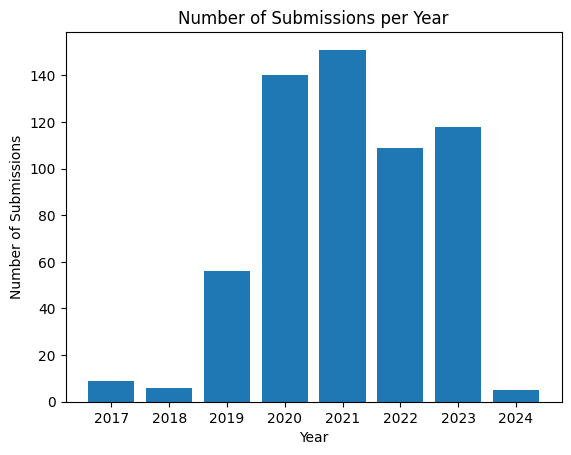

In [19]:
# QUESTION: How did the volume of posts on the SUTD subreddit change over the years?
# Create a bar chart diagram that plots the number of submissions per year on the y-axis and the year on the x-axis.

#--- ADD YOUR SOLUTION HERE (8 points) ---
submissions_per_year = df_submissions['Created'].dt.year.value_counts().sort_index()
plt.bar(submissions_per_year.index, submissions_per_year.values)

plt.xlabel('Year')
plt.ylabel('Number of Submissions')
plt.title('Number of Submissions per Year')
plt.show()

#------------------------------

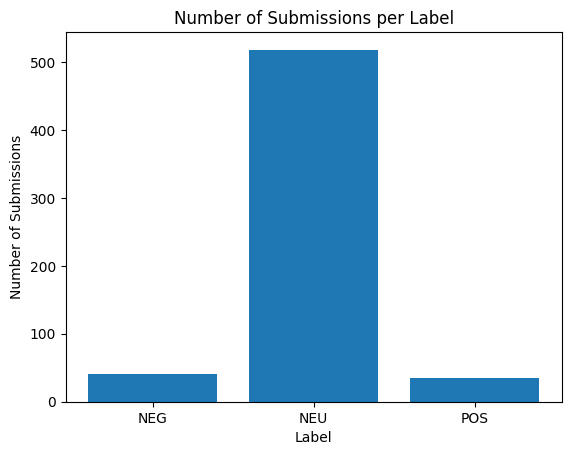

In [20]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment?
# Create a bar chart diagram that plots the number of submissions on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
submissions_per_label = df_submissions['Label'].value_counts().sort_index()
plt.bar(submissions_per_label.index, submissions_per_label.values)

plt.xlabel('Label')
plt.ylabel('Number of Submissions')
plt.title('Number of Submissions per Label')
plt.show()

#------------------------------

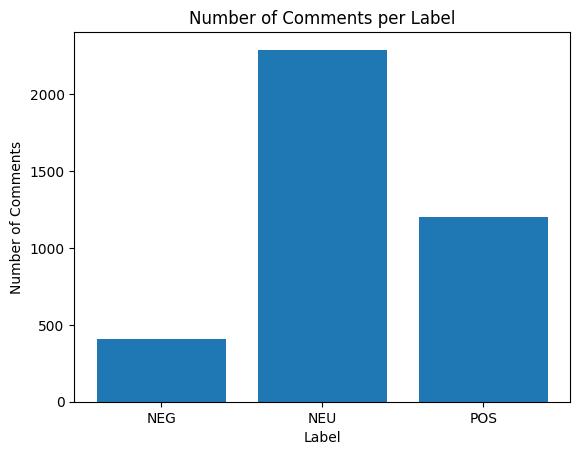

In [21]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment for comments?
# Create a bar chart diagram that plots the number of comments on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
comments_per_label = df_comments['Label'].value_counts().sort_index()
plt.bar(comments_per_label.index, comments_per_label.values)

plt.xlabel('Label')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per Label')
plt.show()

#------------------------------

In [22]:
# QUESTION: combine submission titles and comments for the time period from 2021 until today into one data frame.
# The resulting data frame 'df_text' should have the following schema

# Id - unique id of the comment or the submissions, this column is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML

#--- ADD YOUR SOLUTION HERE (10 points)---
start_date = '2021-01-01'
df_submissions_from2021 = df_submissions[(df_submissions['Created'] >= start_date) & (df_submissions['Created'] 
                                                                                      <= latest_timestamp)]
df_comments_from2021 = df_comments[(df_comments['CommentCreated'] >= start_date) & (df_comments['CommentCreated'] 
                                                                                    <= latest_timestamp)]

df_submissions_from2021 = df_submissions_from2021.rename(columns={'Title': 'Text'})
df_submissions_from2021 = df_submissions_from2021.reset_index()
df_submissions_from2021 = df_submissions_from2021[['Id', 'Text', 'Created', 'Label']]

df_comments_from2021 = df_comments_from2021.rename(columns={'Comment': 'Text'})
df_comments_from2021 = df_comments_from2021[['Id', 'Text', 'CommentCreated', 'Label']]
df_comments_from2021.columns = ['Id', 'Text', 'Created', 'Label']

df_text = pd.concat([df_submissions_from2021, df_comments_from2021]).set_index('Id')

#------------------------------

In [23]:
# inspect the resulting data frame
df_text

,Text,Created,Label
Id,,,
xtdia0,"Oh boy, 8am lectures. My favorite",2022-10-02 02:49:01,POS
scyaig,IF I get my engineering degree,2022-01-26 05:24:35,NEU
zzxqop,Happy New Year!,2022-12-31 16:26:57,POS
rbe5cz,Happy finals!,2021-12-08 00:45:22,POS
zlci46,You know who you are,2022-12-14 00:46:23,NEU
...,...,...,...
13jqat4,hey! got my acceptance today,2023-05-19 12:45:12,POS
13jqat4,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,NEG
13jqat4,I’m an international student from china and I ...,2023-06-13 22:37:17,NEG


In [24]:
# QUESTION: sort the data frame by date time descending and save it in the same variable

#--- ADD YOUR SOLUTION HERE (3 points)---
df_text.sort_values(by='Created', ascending=False, inplace=True)

#------------------------------

In [25]:
# inspect the resulting data frame
df_text

,Text,Created,Label
Id,,,
wur3a6,Unfortunately no and I don’t foresee it to cha...,2024-01-24 03:39:32,NEG
wur3a6,Hi! I would like to ask if it is possible for ...,2024-01-24 03:38:13,NEU
wur3a6,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS
wur3a6,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS
wur3a6,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS
...,...,...,...
kovm76,Yes. I am indoneisan myself. In fact we have a...,2021-01-03 04:32:08,NEU
kpde9d,Subjects in Year 1,2021-01-03 04:13:53,NEU
kp0zuf,HASS mod recommendation,2021-01-02 17:02:09,NEU


In [26]:
# save data frame to csv
df_text.to_csv("reddit.csv")


Download the csv file and open it in a spreadsheet application or text editor. 

Inspec the first 10-20 entries in the list to get a feeling for the data domain.

### QUESTION: 
Write a short labeling guide for annotating the SUTD reddit data with sentiment labels. 
You can write the labeling guide in a bullet point format and should have 5-10 points.

**--- ADD YOUR SOLUTION HERE (10 points)---**

- Assign one of three sentiment labels, 'NEG' (negative), 'NEU' (neutral), or 'POS' (positive), based on the overall emotional tone of the text.
- 'NEG' labels convey overall discontent or dissatisfaction and may be confrontational. 'NEU' labels lack any strong emotional tone and may simply be statements or questions. 'POS' labels convey overall optimism, satisfaction, or approval.
- Read the entire text and take into account case, punctuation, sarcasm, humour, and context where appicable before assigning a label.
- Assign the label which best describes the dominant emotional tone of the text. Assign 'NEU' if the text is equal parts 'NEG' and 'POS'.
- For example, consider the following text: "Oh boy, 8am lectures. My favorite" (Id: xtdia0). This would be labeled as 'NEG' due to the sarcasm and dissatisfied tone in the context of 8am lectures in SUTD.

------------------------------


## Label the data
Add a new column 'HumanLabel' to the csv file and label the 500 most recent entries, including the first 10-20 you inspected to create the label guide, using a spreadsheet application (Excel, Google Docs, Numbers) or just a text editor. 

### QUESTION: 
What were some of the ambiguous cases or corner cases you encountered?
List 3-5 issues

**--- ADD YOUR SOLUTION HERE (30 points)---**

1. 'Fun if you join fifth rows that you like. Yeah the campus is a bit small and food options are limited. I personally like SUTD because of the distance from my house and dislike SUTD because the curriculum is hectic and sometimes I regret not going to NUS because I will have more free time for my own interests' (Id 13noqhc, Predicted: POS -> Labeled: NEG)

The first statement initially looks positive. However, it is actually a more neutral statement since the 'fun' is only derived on the condition that one joins a fifth row they like. The rest of the text carries a more pessimistic tone, other than the comment on distance from their house. Even then, it is quite superficial compared to the other points. Hence, I assigned the NEG label.

2. 'oh wells. yea you are right, gotta stay positive and press on  :)  i'm just gonna re-evaluate everything i have so far, and then get ready for 2024's round.' (Id 13s6si3, Predicted: POS -> Labeled: NEU)

Despite the comment on staying positive and the smiling emoji, this text carries the tone of resigned acceptance instead of optimism. However, as it is also not heavily pessimistic, I assigned it as NEU.

3. 'Yo! I got in with 3.5 cgpa and got global merit scholarship. Didn't get any technical qns, the interview was super chill. Its 1 on 1, and they try to break the ice before they start asking further interview qns. Mainly things like why SUTD and Why SUTD and not NTU (yea got asked this lol). Oh another is they will try to scare you by listing out their very aggressive curriculum, how you needa learn fast and u have to convince them you will thrive not survive in the fast paced curriculum. Bonus points if u state something unique about urself that they don't alr know abt in your application they obviously have read up. For example "most fun hackathon experience" or "can take apart and rebuild a car engine" etc etc. Anyways this was for me, if u read last years sutd interview thread shd find more info. Atb!' (Id 18xokte, Predicted: NEU -> Labeled: POS)

Despite the comment consisting mostly of statements, it carries an overall optimistic and encouraging tone due to the vocabulary and punctuation. The creator seems to be reassuring the addressee, even wishing them 'all the best' at the end. Thus, I assigned the POS label.

4. 'chill meh? arent we known for staying up' (Id 17uf6wv, Predicted: NEU -> Labeled: NEG)

Despite appearing as a statement, the colloquial use of 'meh' lends a pessimistic tone to the text. The act of 'staying up' and being 'known for it' is also not something to be celebrated due to the poor quality of life it implies. Hence, I assigned the NEG label.

------------------------------


Upload your 500 labeled instances as **reddit_labeled.csv** to JupyterLab.

## Evaluate
Compare your human-corrected labels with the original predicted labels.

In [27]:
# 
# QUESTION: Read the 500 labeled rows from the CSV file into a dataframe "df_labeled". 
# The data frame should have this schema.

# Id - unique id of the comment or the submissions, Id is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML
# HumanLabel - manually reviewed 'gold sentiment label'

#--- ADD YOUR SOLUTION HERE (5 points)---
df_labeled = pd.read_csv('reddit_labeled_wintun_kyaw.csv')
df_labeled = df_labeled.dropna(subset=['HumanLabel'])

#------------------------------


In [28]:
# check the data was loaded correctly
df_labeled

,Id,Text,Created,Label,HumanLabel
0,wur3a6,Unfortunately no and I don’t foresee it to cha...,24/1/2024 3:39,NEG,NEG
1,wur3a6,Hi! I would like to ask if it is possible for ...,24/1/2024 3:38,NEU,NEU
2,wur3a6,"Thks! Hope you have a great FEAST II, all the ...",23/1/2024 14:25,POS,POS
3,wur3a6,"I see, wishing you all the best for the result...",23/1/2024 13:50,POS,POS
4,wur3a6,"Haha yup, should be out by tmr. Yes, FEAST II ...",23/1/2024 13:34,POS,POS
...,...,...,...,...,...
495,13rjik9,Entered having not taken physics since sec 2 b...,27/5/2023 9:33,NEU,NEU
496,13noqhc,Fun if you join fifth rows that you like. Yeah...,27/5/2023 5:57,POS,NEG
497,13s2art,"If you have access to a gpu cloud, anything goes",27/5/2023 4:04,POS,NEU
498,wur3a6,OOo i see!! Any medical examination requiremen...,27/5/2023 3:48,NEU,NEU


In [29]:
# split the labeled data into two chunks, ordered by time
df_labeled.sort_values('Created', ascending=True, inplace=True)

df_labeled1 = df_labeled[:250]
df_labeled2 = df_labeled[250:]

In [30]:
# check that the each split is 250 instances and that they don't overlap
df_labeled1


,Id,Text,Created,Label,HumanLabel
48,18vqvy4,https://www.reddit.com/r/sutd/s/71Bv8Bg6Xr,1/1/2024 15:40,NEU,NEU
49,18vqvy4,Seeking Scholarship Info and Funding Guidance,1/1/2024 6:36,NEU,NEU
452,13wf7ee,let's be friends!! :),1/6/2023 11:49,POS,POS
451,13xltzi,SS ILP Experience,1/6/2023 16:16,NEU,NEU
457,13wf7ee,count me in!!!!,1/6/2023 2:54,POS,POS
...,...,...,...,...,...
197,15z98ej,any laptop works if going csd. only maybe arch...,23/8/2023 23:07,NEU,NEU
1,wur3a6,Hi! I would like to ask if it is possible for ...,24/1/2024 3:38,NEU,NEU
0,wur3a6,Unfortunately no and I don’t foresee it to cha...,24/1/2024 3:39,NEG,NEG
87,182vwyh,Exchange at SUTD,24/11/2023 16:28,NEU,NEU


In [31]:
df_labeled2


,Id,Text,Created,Label,HumanLabel
55,11zlqf5,Hi! So what does the exam covers?,24/12/2023 10:10,NEU,NEU
54,11wbttp,Hi! So what does the uee covers?,24/12/2023 10:11,NEU,NEU
342,14gq019,Enter through EASE and access outlook 365 on t...,24/6/2023 18:05,NEU,NEU
341,1455ee7,If u r sgporean no need chest x ray,24/6/2023 18:15,NEU,NEU
346,14gz6nq,Current SUTD student here!\n\nI'm happy to hel...,24/6/2023 6:02,POS,POS
...,...,...,...,...,...
282,14unoe5,20 - successful appeal outcome \n17 - unsucces...,9/7/2023 6:04,NEU,NEU
281,14unoe5,"utterly devastated, got a good decent rp, they...",9/7/2023 7:47,NEG,NEG
222,15m2494,ur sutd email is just ur first name_lastname@m...,9/8/2023 5:33,NEU,NEU
179,wur3a6,"Good day sir, Im taking my Feast test 2 this c...",9/9/2023 10:01,NEU,NEU


In [32]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 1. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled1["Label"], df_labeled1["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.95      0.62      0.75        29
         NEU       0.83      0.98      0.90       164
         POS       0.89      0.58      0.70        57

    accuracy                           0.85       250
   macro avg       0.89      0.73      0.78       250
weighted avg       0.86      0.85      0.84       250



In [33]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 2. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled2["Label"], df_labeled2["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.91      0.68      0.78        31
         NEU       0.80      0.98      0.88       148
         POS       0.96      0.62      0.75        71

    accuracy                           0.84       250
   macro avg       0.89      0.76      0.80       250
weighted avg       0.86      0.84      0.83       250



## Retrain sentiment model

Now let us use the data in df_labeled1 to try improve the sentiment classifier.
Train the Huggingface model you have chosen with the 250 examples and your human gold labels.

Start by converting the data from data frames into a 2 Huggingface datasets. 
- dataset1 : a Huggingface dataset object which includes the data from dataframe df_labeled1
- dataset2 : a Huggingface dataset object which includes the data from dataframe df_labeled2


In each dataset, there should be the following fields
- text : the text of the reddit submission or comment
- label: the human gold label, encoded as integer

With these dataset we will simulate the process of improving a model in production. Dataset1 is simulating a batch of data which we observed in production, annotated and then use to improve the model. We evaluate the change on the new training data and on the next batch of production data, simulated by dataset2.


In [34]:
def convert_label(df, pipeline):
    # drop predicted label column
    df = df.drop("Label", axis=1)
    # convert string labels to integers as column 'label' using the sentiment pipeline config
    label_id_mapping = lambda label: pipeline.model.config.label2id[label]
    df['label'] = df['HumanLabel'].apply(label_id_mapping)
    return df

df_labeled1 = convert_label(df_labeled1, sentiment_pipeline)
df_labeled2 = convert_label(df_labeled2, sentiment_pipeline)

In [35]:
# QUESTION: Convert the text and human labels from the data frame to a huggingface dataset format
# create a huggingface 'dataset1' from data frame 'df_labeled1' and 'dataset2' from data frame 'df_labeled2' 
#
# each dataset has the following fields
# text : the text of the reddit submission or comment
# label: the human gold label, encoded as integer

#--- ADD YOUR SOLUTION HERE (5 points)---
df_labeled1 = df_labeled1.rename(columns={'Text': 'text'})
df_labeled2 = df_labeled2.rename(columns={'Text': 'text'})

dataset1 = Dataset.from_pandas(df_labeled1[['text', 'label']])
dataset2 = Dataset.from_pandas(df_labeled2[['text', 'label']])

#------------------------------



In [36]:
# inspect the first example
dataset1[0]

{'text': 'https://www.reddit.com/r/sutd/s/71Bv8Bg6Xr',
 'label': 1,
 '__index_level_0__': 48}

In [37]:
# load tokenizer and tokenize data set
# 
# QUESTION: Load the required tokenizer from Huggingface into a variable 'tokenizer'
# Then tokenize 'dataset1' into 'tokenized_dataset1' and 'dataset2' into 'tokenized_dataset2'
# Use the Huggingface libraries. Remember that we stored the model name in a variable "model_name"

# helper function for tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=128)

#--- ADD YOUR SOLUTION HERE (5 points)---
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset1 = dataset1.map(tokenize_function, batched=True)
tokenized_dataset2 = dataset2.map(tokenize_function, batched=True)

#------------------------------



Map: 100%|██████████| 250/250 [00:00<00:00, 2978.54 examples/s]


In [38]:
# load Hugging model for classification initialized with the sentiment model you have chosen

#--- ADD YOUR SOLUTION HERE (3 points)---
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

#------------------------------
# Hint: make sure your model corresponds to your tokenizer

In [39]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [40]:

#
# QUESTION: configure the training parameters using the Hugginface TrainingArguments class
# - set the output directory to "finetuning-reddit"
# - do not report training metrics to an external experiment tracking service
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set logging_steps to 10,
# - set evaluation_strategy to "steps",
# - set epochs to 3


#--- ADD YOUR SOLUTION HERE (3 points)---
training_args = TrainingArguments(
    output_dir = 'finetuning-reddit',
    learning_rate = 2e-5,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps = 10,
    num_train_epochs = 3,
    report_to = None,
)

#------------------------------



In [41]:
# initialize trainer
# train on the split dataset1
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset1,
    eval_dataset=tokenized_dataset2,
    compute_metrics=compute_metrics,
)

In [42]:
# Evaluate on dataset1 set before training 
predictions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset1['label']))


              precision    recall  f1-score   support

           0       0.95      0.62      0.75        29
           1       0.83      0.98      0.90       164
           2       0.89      0.58      0.70        57

    accuracy                           0.85       250
   macro avg       0.89      0.73      0.78       250
weighted avg       0.86      0.85      0.84       250



In [43]:
# Evaluate on dataset2 set before training 
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


              precision    recall  f1-score   support

           0       0.91      0.68      0.78        31
           1       0.80      0.98      0.88       148
           2       0.96      0.62      0.75        71

    accuracy                           0.84       250
   macro avg       0.89      0.76      0.80       250
weighted avg       0.86      0.84      0.83       250



In [44]:
# train the model
train_output = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,0.449100,0.454057,0.840000,0.832571,0.840000,0.813235
20,0.383800,0.529059,0.796000,0.799998,0.796000,0.756098
30,0.426200,0.367759,0.896000,0.898022,0.896000,0.895250
40,0.262600,0.359528,0.876000,0.883222,0.876000,0.878338
50,0.193400,0.337041,0.880000,0.881416,0.880000,0.879461
60,0.060000,0.400104,0.856000,0.855330,0.856000,0.849455
70,0.034800,0.421547,0.848000,0.846299,0.848000,0.839685
80,0.108200,0.382385,0.868000,0.868543,0.868000,0.865887
90,0.045900,0.381420,0.872000,0.872733,0.872000,0.870636


In [45]:
# Evaluate on dataset1, i.e the training set again
preditions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(preditions.predictions.argmax(-1), dataset1['label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.98      0.99      0.99       192
           2       0.97      0.92      0.95        39

    accuracy                           0.98       250
   macro avg       0.99      0.97      0.98       250
weighted avg       0.98      0.98      0.98       250



In [46]:
# Evaluate on dataset2 set i.e. the test set again
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


              precision    recall  f1-score   support

           0       0.65      0.88      0.75        17
           1       0.92      0.90      0.91       185
           2       0.78      0.75      0.77        48

    accuracy                           0.87       250
   macro avg       0.79      0.85      0.81       250
weighted avg       0.88      0.87      0.87       250



### QUESTION: 
Has the model improved performance on the first batch of data? Does the model generalize well to the next batch of data?
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points)---**

The model performs very well on the first batch of data. However, it seems to be overfitting on the test set. This is especially so for the NEG/0 label and the POS/2 label. A possible reason for this is there are very few samples for the NEG and POS labels in the training set, which made the model overfit on those few samples.

------------------------------


### QUESTION: 
Is the model good enough to be used for practical applications?
Given the results you have so far, what additional measures would you recommend to continuously improve the SUTD reddit sentiment classifier? What other functionalities beyond sentiment could be useful? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

No, because it is only good at identifying neutral sentiments. To improve its performance, I would recommend finetuning the model on more negative and positive labels. Additionally, a larger portion or even the entire dataset should be used to train the model instead of a small 250 subset. As a step further, it would be ideal if the labeler is also the creator of the text as only the creator is truly certain of the intent of their post. Besides sentiment, topic modeling or classification could be useful for this dataset, as most of it consists of questions and answers to various common topics such as interviews, scholarships, hostel life, and application results.

------------------------------


# End

This concludes assignment 2.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** (assignment_02_STUDENT_NAME.ipynb) and the **text file reddit_labeled_STUDENT_NAME.csv** via the eDimensions tool, where STUDENT_NAME is your name in your SUTD email address.

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan

Submission file name: assignment_02_michael_tan.ipynb


**Assignment due 8 March 11:59pm**


